In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats



In [ ]:
# Load the Parquet file
merged_df_cleaned = pd.read_parquet('Data/cleaned_price_data.parquet', engine='pyarrow')


In [19]:
merged_df_cleaned = pd.read_csv('cleaned_price_data.csv')

C:\Users\DELL\AppData\Local\Temp\ipykernel_9812\3000706049.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df_cleaned = pd.read_csv('cleaned_price_data.csv')


In [20]:
# Step 1: Separate out the rows where products were on sale
sale_df = merged_df_cleaned[merged_df_cleaned['other'] == 'SALE']

# Create price change columns for before and after sale for comparison
# We need to shift the prices by the 'product_id' and 'nowtime' columns to align "before" and "after" prices

# Sort by product_id and nowtime to ensure we can calculate the correct price differences
sale_df = sale_df.sort_values(by=['product_id', 'nowtime'])

# Add 'price_before_sale' and 'price_after_sale' columns by shifting the prices
sale_df['price_before_sale'] = sale_df.groupby('product_id')['current_price'].shift(1)
sale_df['price_after_sale'] = sale_df.groupby('product_id')['current_price'].shift(-1)

# Drop any rows where 'price_before_sale' or 'price_after_sale' are NaN (i.e., no price change data)
sale_df_cleaned = sale_df.dropna(subset=['price_before_sale', 'price_after_sale'])


In [21]:
# Step 2: Shapiro-Wilk Test for normality
shapiro_before = stats.shapiro(sale_df_cleaned['price_before_sale'])
print(f"Shapiro-Wilk Test for 'price_before_sale': Statistic = {shapiro_before[0]}, p-value = {shapiro_before[1]}")

# Shapiro-Wilk Test for 'price_after_sale'
shapiro_after = stats.shapiro(sale_df_cleaned['price_after_sale'])
print(f"Shapiro-Wilk Test for 'price_after_sale': Statistic = {shapiro_after[0]}, p-value = {shapiro_after[1]}")


Shapiro-Wilk Test for 'price_before_sale': Statistic = 0.7972990870475769, p-value = 0.0
Shapiro-Wilk Test for 'price_after_sale': Statistic = 0.7972496747970581, p-value = 0.0


h:\Software\Anaconda\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [22]:
# Step 3: Wilcoxon signed-rank test for non-parametric data
# If the data is not normally distributed, use this test
wilcoxon_stat, wilcoxon_p_value = stats.wilcoxon(sale_df_cleaned['price_before_sale'],
                                                 sale_df_cleaned['price_after_sale'])

print(f"Wilcoxon signed-rank test: statistic = {wilcoxon_stat}, p-value = {wilcoxon_p_value}")
if wilcoxon_p_value < 0.05:
    print("There is a statistically significant difference between prices before and after sales.")
else:
    print("There is no statistically significant difference between prices before and after sales.")


Wilcoxon signed-rank test: statistic = 82835093.0, p-value = 0.0020699481778285885
There is a statistically significant difference between prices before and after sales.


In [23]:
# Step 4: Correlation analysis between price changes before and after sale
correlation_before_after = sale_df_cleaned['price_before_sale'].corr(sale_df_cleaned['price_after_sale'])
print(f"Correlation between price changes before and after sale: {correlation_before_after}")


Correlation between price changes before and after sale: 0.9973845218317363


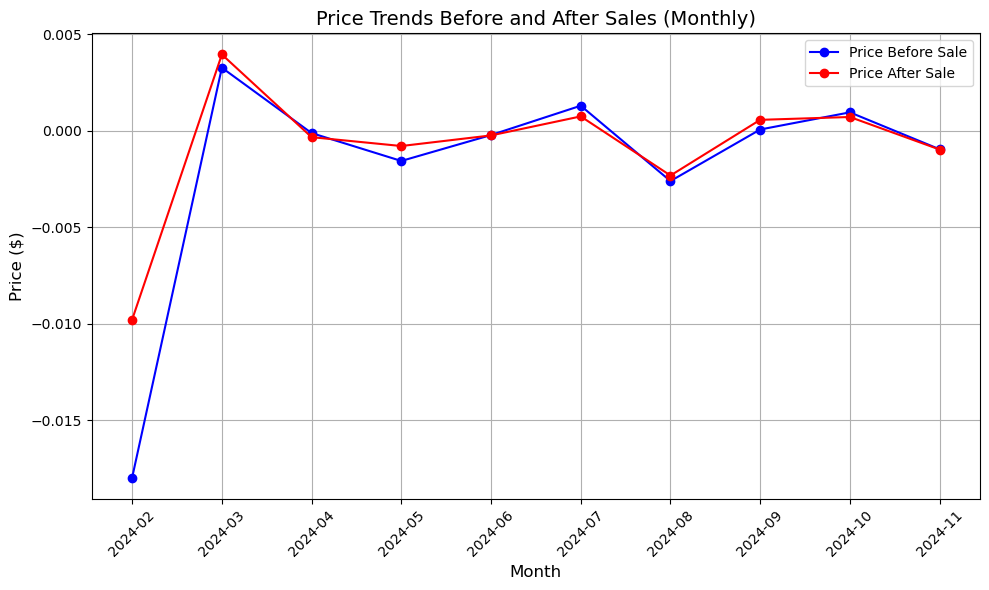

In [24]:
import matplotlib.pyplot as plt

# Step 1: Convert 'nowtime' to datetime format if not already
merged_df_cleaned['nowtime'] = pd.to_datetime(merged_df_cleaned['nowtime'])

# Step 2: Extract year and month from 'nowtime' column
merged_df_cleaned['year_month'] = merged_df_cleaned['nowtime'].dt.to_period('M')

# Step 3: Group by year_month and calculate the mean price before and after sales
monthly_prices = merged_df_cleaned.groupby('year_month').agg({
    'price_change_before_sale': 'mean',
    'price_change_after_sale': 'mean'
}).reset_index()

# Step 4: Plotting the time series for prices before and after sale
plt.figure(figsize=(10, 6))
plt.plot(monthly_prices['year_month'].astype(str), monthly_prices['price_change_before_sale'], label='Price Before Sale', color='blue', marker='o')
plt.plot(monthly_prices['year_month'].astype(str), monthly_prices['price_change_after_sale'], label='Price After Sale', color='red', marker='o')

# Step 5: Formatting the plot
plt.title('Price Trends Before and After Sales (Monthly)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Step 6: Show the plot
plt.tight_layout()
plt.show()


In [25]:
print(merged_df_cleaned.columns)


Index(['nowtime', 'current_price', 'old_price', 'other', 'product_id',
       'vendor', 'product_name', 'units', 'pre_sale_price', 'post_sale_price',
       'price_change_before_sale', 'price_change_after_sale', 'year_month'],
      dtype='object')
